In [1]:
import os
import shutil
from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0



In [2]:
def naive_estimator(spikes, nonzero_inds=None):
    "spikes has shape (time, unit, trial)"
    n_f0 = jnp.fft.rfft(spikes, axis=0)
    n_f = n_f0[1:,:,:]
    naive_est = jnp.einsum('jkl,jil->jkil', n_f, n_f.conj()).mean(-1)

    if nonzero_inds is None:
        return naive_est
    else:
        return naive_est[nonzero_inds, :, :]


In [3]:
def clean_dir(path):
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

In [4]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

In [5]:
def transform(spec, dB=True):
    if dB is True:
        return 10*jnp.log10(spec+1e-15)
    else:
        return spec

In [25]:
alpha = 200
num_iters = 20
lcfg_attrs = {'gamma': 'k2-full-multitarget1',
              'scale': 1e4}

mcfg_attrs = {'init': 'empirical-init',
              'emiters': num_iters}

ocfg_attrs = {'obs_type': 'pp_relu',
              'alpha': alpha}

In [26]:
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/pp_relu_obs/outputs/2024-09-17']
for res_path in res_paths:
    clean_dir(res_path)

results = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
Ls = sorted([r['cfg'].latent.L for r in results])
print(Ls)

1 paths found meeting critera
[50]


Returned single result.


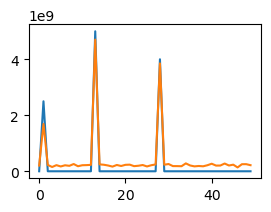

In [27]:
L = Ls[0]
lsel = {'L': L}
res = filter_loaded(results, lsel, {}, {})

gamma_true = res['gamma_true_full']
gamma_est = res['gamma']
gamma_init = res['gamma_init']
nz = jnp.arange(50)
k = 0
fig,ax = plt.subplots(figsize=(3,2))
ax.plot(gamma_true[nz,k,k].real)
# ax.plot(gamma_est[:,k,k].real)
ax.plot(gamma_init[:,k,k].real)
# plt.ylim([0,1e6])

Returned single result.


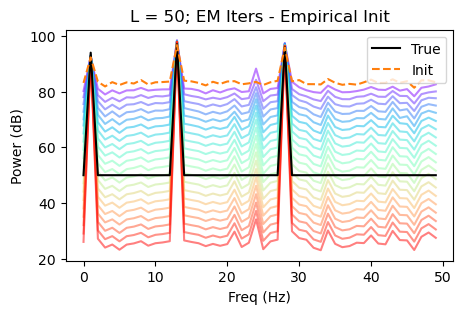

In [28]:
for L in Ls:
    lsel = {'L': L}
    res = filter_loaded(results, lsel, {}, {})

    dB = True
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    skip = 0
    fig, ax = plt.subplots(figsize=(5,3))
    for r, c in enumerate(color[skip:]):
        S_r = transform(res['track']['gamma'][r+skip][:,k,k].real, dB=dB)
        ax.plot(S_r, color=c, alpha=0.5)
    S_init = transform(res['gamma_init'][:,k,k].real, dB=dB)
    S_true = transform(gamma_true[nz,k,k].real, dB=dB)
    ax.plot(S_true, color='k', label='True')
    ax.plot(S_init, color='tab:orange', linestyle='--', label='Init')
    ax.set_xlabel('Freq (Hz)')
    if dB is False:
        ax.set_ylabel('Power')
    else: 
        ax.set_ylabel('Power (dB)')
    ax.set_title(f'L = {L}; EM Iters - Empirical Init')
    ax.legend()

In [29]:
# Great - much better behavior

In [30]:
# Unfortunatley, coherence is wacky now!

In [31]:
L = 50
lsel = {'L': L}
res = filter_loaded(results, lsel, {}, {})

gamma_est = res['gamma']
gamma_init = res['gamma_init']

Returned single result.


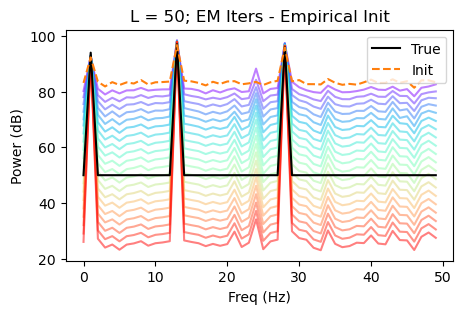

In [32]:
dB = True
color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
fig, ax = plt.subplots(figsize=(5,3))
for r, c in enumerate(color):
    S_r = transform(res['track']['gamma'][r][:,k,k].real, dB=dB)
    ax.plot(S_r, color=c, alpha=0.5)
S_init = transform(res['gamma_init'][:,k,k].real, dB=dB)
S_true = transform(gamma_true[nz,k,k].real, dB=dB)
ax.plot(S_true, color='k', label='True')
ax.plot(S_init, color='tab:orange', linestyle='--', label='Init')
ax.set_xlabel('Freq (Hz)')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
ax.set_title(f'L = {L}; EM Iters - Empirical Init')
ax.legend()

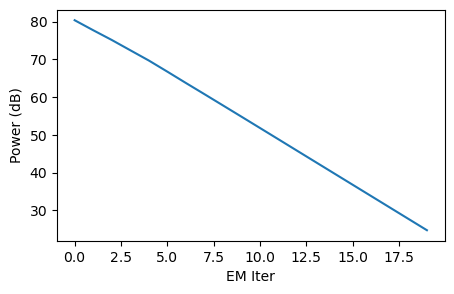

In [33]:
k = 0
skip = 0
init_val = transform(gamma_init[28,k,k].real, dB=dB)
em_target = jnp.array([transform(res['track']['gamma'][r+skip][9,k,k].real, dB=dB) for r in range(num_iters-skip)])
em_target = jnp.insert(em_target, 0, init_val)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(em_target[1:])
# ax.axhline(transform(gamma_true[9,k,k].real, dB=dB), color='k', linestyle='--', label='True Value')
# ax.legend()
ax.set_xlabel('EM Iter')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
# ax.set_title(f'Target value with flat init at {res["cfg"].model.init_mod * gamma_true[9,k,k].real:.2E}')

In [34]:
from cohlib.jax.dists import sample_obs
cfg = res['cfg'] 

lseed = cfg.latent.seed
L = cfg.latent.L

zs = sample_from_gamma(jr.key(lseed), gamma_true, L)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
ocfg = cfg['obs']
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

obs, obs_params = sample_obs(ocfg, xs)
gamma_naive = naive_estimator(obs, nz)

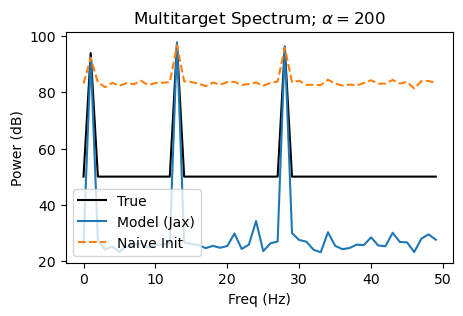

In [40]:
alpha = ocfg.alpha
dB = True 
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(transform(gamma_true[nz,k,k].real, dB=dB), color='k', label='True')
ax.plot(transform(gamma_est[:,k,k].real, dB=dB), label='Model (Jax)')
ax.plot(transform(gamma_init[:,k,k].real, dB=dB), linestyle='--', color='tab:orange', label='Naive Init')
# ax.plot(transform(gamma_naive[:,k,k].real * 1e6, dB=dB), color='tab:red', label='Naive')
ax.set_title(r'Multitarget Spectrum; $\alpha = $' + f'{alpha}')

ax.set_xlabel('Freq (Hz)')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
ax.legend()
# ax.set_xlim([8,12])

(0.0, 1.0)

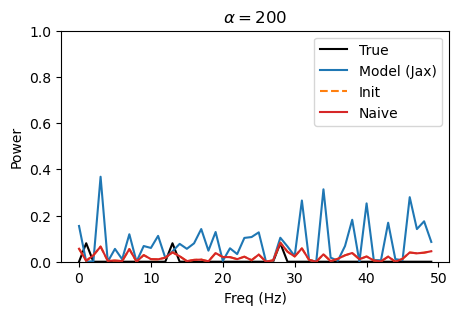

In [36]:
from cohlib.mvcn import thr_coherence
dB = False 
gamma_naive = naive_estimator(obs, nz)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(thr_coherence(gamma_true[nz,:,:]), color='k', label='True')
ax.plot(thr_coherence(gamma_est[:,:,:]), label='Model (Jax)')
ax.plot(thr_coherence(gamma_init[:,:,:]), linestyle='--', color='tab:orange', label='Init')
ax.plot(thr_coherence(gamma_naive[:,:,:] * 1e6), color='tab:red', label='Naive')
ax.set_title(r'$\alpha = $' + f'{alpha}')

ax.set_xlabel('Freq (Hz)')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
ax.legend()
ax.set_ylim([0,1])

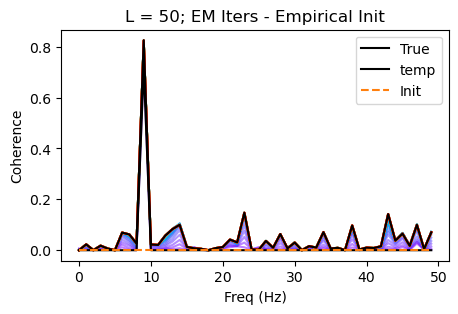

In [111]:
color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
fig, ax = plt.subplots(figsize=(5,3))
for r, c in enumerate(color):
    # S_r = transform(res['track']['gamma'][r][:,k,k].real, dB=dB)
    coh_r = thr_coherence(res['track']['gamma'][r])
    ax.plot(coh_r, color=c, alpha=0.5)
# coh_true = thr_coherence(gamma_true[nz,:,:])
# coh_init = thr_coherence(res['gamma_init'])
coh_true = thr_coherence(gamma_true[nz,:,:])
coh_init = thr_coherence(res['gamma_init'])
coh_temp = thr_coherence(res['gamma'])
ax.plot(coh_true, color='k', label='True')
ax.plot(coh_temp, color='k', label='temp')
ax.plot(coh_init, color='tab:orange', linestyle='--', label='Init')
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('Coherence')
ax.set_title(f'L = {L}; EM Iters - Empirical Init')
ax.legend()

But, this was not hapening previously? 
... look back at other plots (i.e. from flat init)

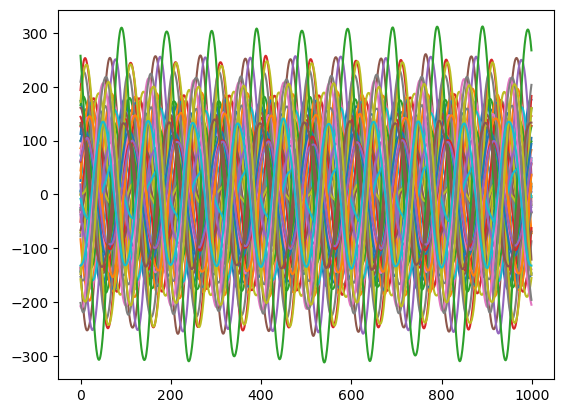

In [51]:
L = xs.shape[-1]
for l in range(L):
    plt.plot(xs[:,0,l])

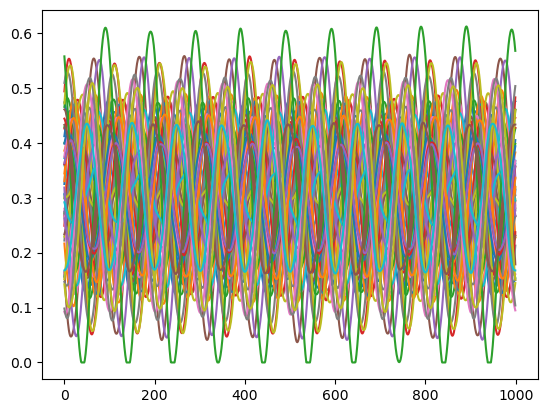

In [52]:
alpha = cfg.obs.alpha
for l in range(L):
    lams = (alpha + xs[:,0,l])*1e-3
    lams = lams.at[lams < 0].set(0)
    plt.plot(lams)